In [1]:
import tensorflow as tf
%pylab inline
import pickle

import itertools
import os
import pandas as pd

import networkx as nx
import umap

%env CUDA_VISIBLE_DEVICES=0

Populating the interactive namespace from numpy and matplotlib
env: CUDA_VISIBLE_DEVICES=0


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
    # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
import hosgns
from utils import *

In [4]:
# preprocess dataset
dataset = 'LyonSchool'
AGGR_TIME = 10*60
partial_times, s_temp_net, df_tnet = load_temp_data(dataset, AGGR_TIME)

In [5]:
# rename nodes and time slices
map_node_index = {node:index for index, node in \
                  enumerate(np.unique(s_temp_net.reset_index()[['i', 'j']].values.flatten()))}
map_time_index = {time:index for index, time in \
                  enumerate(np.unique(s_temp_net.reset_index().tslice.values))}
NR_NODES = len(map_node_index)
NR_TIMES = len(map_time_index)

df_tnet['tslice'] = df_tnet['tslice'].map(map_time_index) 
df_tnet['i'] = df_tnet['i'].map(map_node_index) 
df_tnet['j'] = df_tnet['j'].map(map_node_index)

In [6]:
# load metadata
metadata = pd.read_csv('../data/metadata/metadata_%s.dat' % dataset, sep='\t', names=['node', 'label'])
metadata['node']=metadata.node.map(map_node_index)
map_node_class = dict(metadata[['node', 'label']].values)

In [7]:
# load network and default list of active nodes
supra_G = pickle.load(open('../preprocessed/SupraAdjacencyMatrix/%s/Stat/Aggtime%d.gpickle' % (dataset, AGGR_TIME), 'rb'))
pat_active_time = pickle.load(open('../preprocessed/SupraAdjacencyMatrix/%s/PatActiveTimeAggtime%d.pkl'% (dataset,AGGR_TIME), 'rb'))
node_active_time = np.array([str(map_node_index[int(n_node.split('-')[0])])+'-'+\
                                 str(map_time_index[int(n_node.split('-')[1])]) for n_node in pat_active_time])
times = [int(x.split('-')[1]) for x in node_active_time]
node_tuple_time = [(int(n_node.split('-')[0]), int(n_node.split('-')[1])) for n_node in node_active_time]

In [8]:
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.utils.extmath import cartesian

# TENSOR FACTORIZATION of 3WAY P(Stat)

In [9]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [10]:
# load probability tensors
Pijk = pickle.load(open('../preprocessed/SupraAdjacencyTensorSparse/%s/Stat/Aggtime%dWay3Redu.pkl'% (dataset, AGGR_TIME), 'rb')).astype(np.float32)
Pi = pickle.load(open('../preprocessed/SupraAdjacencyTensorSparse/%s/Stat/Aggtime%dWay3Redu_V.pkl'% (dataset, AGGR_TIME), 'rb')).todense().astype(np.float32)
Pj = pickle.load(open('../preprocessed/SupraAdjacencyTensorSparse/%s/Stat/Aggtime%dWay3Redu_Z.pkl'% (dataset, AGGR_TIME), 'rb')).todense().astype(np.float32)
Pk = pickle.load(open('../preprocessed/SupraAdjacencyTensorSparse/%s/Stat/Aggtime%dWay3Redu_W.pkl'% (dataset, AGGR_TIME), 'rb')).todense().astype(np.float32)

In [11]:
# reshape p(i,j,k) to a matrix p(ij,k)
Pij = Pijk.reshape((NR_NODES*NR_TIMES, NR_NODES))

In [12]:
# compute indices of active nodes for Pij rows
ij_prod_df = pd.DataFrame(cartesian((np.arange(NR_NODES), np.arange(NR_TIMES))), columns=['n', 't'])
ij_df=pd.DataFrame(Pijk.coords.T[:,:2], columns=['n', 't']).drop_duplicates().reset_index(drop=True)
active_nodes_list = ij_prod_df.reset_index().merge(ij_df, on=['n','t']).loc[:, 'index'].values 

In [13]:
# train 3way-hosgns 
print_every=500
solver = hosgns.HOSGNSSolver(tensor=Pij.todense(), marginals=(Pi,Pj,Pk), active_events_list=active_nodes_list, 
                         emb_dim=128,
                         iters=5000,
                         batch_size=50000, 
                         negative_samples=5,
                         learning_rate=tf.keras.optimizers.schedules.PolynomialDecay(0.05, 5000),
                         warmup_steps=100,
                         random_state=42)
loss = solver.train(print_loss='sg-tf', print_every=print_every)
emb_W, emb_T, emb_C = solver.model.factors

Warmup...
Training...
step    0 - loss: 2.7036330699920654 (9.8302 seconds)
step  500 - loss: 0.7516120672225952 (110.9534 seconds)
step 1000 - loss: 0.6950451731681824 (122.6929 seconds)
step 1500 - loss: 0.6678499579429626 (124.0333 seconds)
step 2000 - loss: 0.6498576402664185 (113.4791 seconds)
step 2500 - loss: 0.6355884671211243 (125.0977 seconds)


/home/spiaggesi/hosgns/code/utils.py:21: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


step 3000 - loss: 0.6237422823905945 (119.5282 seconds)
step 3500 - loss: 0.6133493185043335 (122.6683 seconds)
step 4000 - loss: 0.6037909388542175 (103.1189 seconds)
step 4500 - loss: 0.5948658585548401 (125.4073 seconds)
step 5000 - loss: 0.5865393877029419 (123.7291 seconds)

Total time: 1201.5705 seconds.


Text(0.5, 1.0, '$ \\sum_{ijk}| \\sigma (\\log(\\frac{p_{ijk}}{\\kappa p_ip_jp_k})) - \\sigma (m_{ijk}) |$')

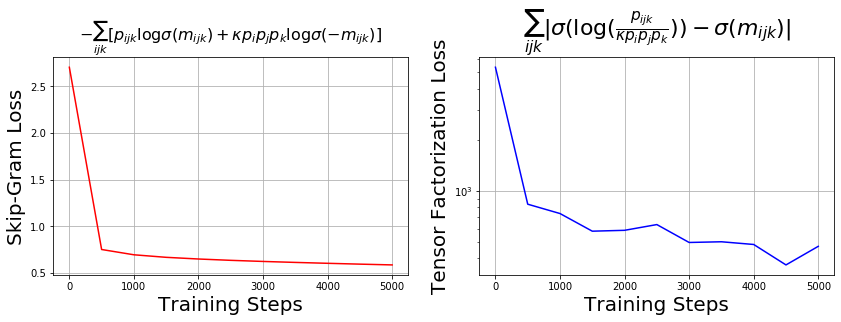

In [14]:
# plot hosgns loss function (left) and the related tensor factorization loss function (right)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))

ax[0].plot(np.arange(len(loss['sg']))*print_every, np.array([t for t in loss['sg']]) ,'r')
ax[0].grid()
ax[0].set_xlabel("Training Steps", fontsize=20)
ax[0].set_ylabel("Skip-Gram Loss", fontsize=20)
ax[0].set_title(r'$ -\sum_{ijk}[ p_{ijk} \log \sigma (m_{ijk}) + \kappa p_ip_jp_k \log \sigma (-m_{ijk})]$', fontsize=16)

ax[1].plot(np.arange(len(loss['tf']))*print_every, np.array([t for t in loss['tf']]) ,'b')
ax[1].set_yscale('log')
ax[1].grid()
ax[1].set_xlabel("Training Steps", fontsize=20)
ax[1].set_ylabel("Tensor Factorization Loss", fontsize=20)
ax[1].set_title(r'$ \sum_{ijk}| \sigma (\log(\frac{p_{ijk}}{\kappa p_ip_jp_k})) - \sigma (m_{ijk}) |$', fontsize=22)

In [15]:
# apply umap to embedding matrices W and T (nodes and times)
emb = umap.UMAP()
X = emb.fit_transform(emb_W.numpy())
emb = umap.UMAP()
Z = emb.fit_transform(emb_T.numpy())

(-5.405872932414713, 6.38436519239396, -6.767212692089515, -1.8247806398196638)

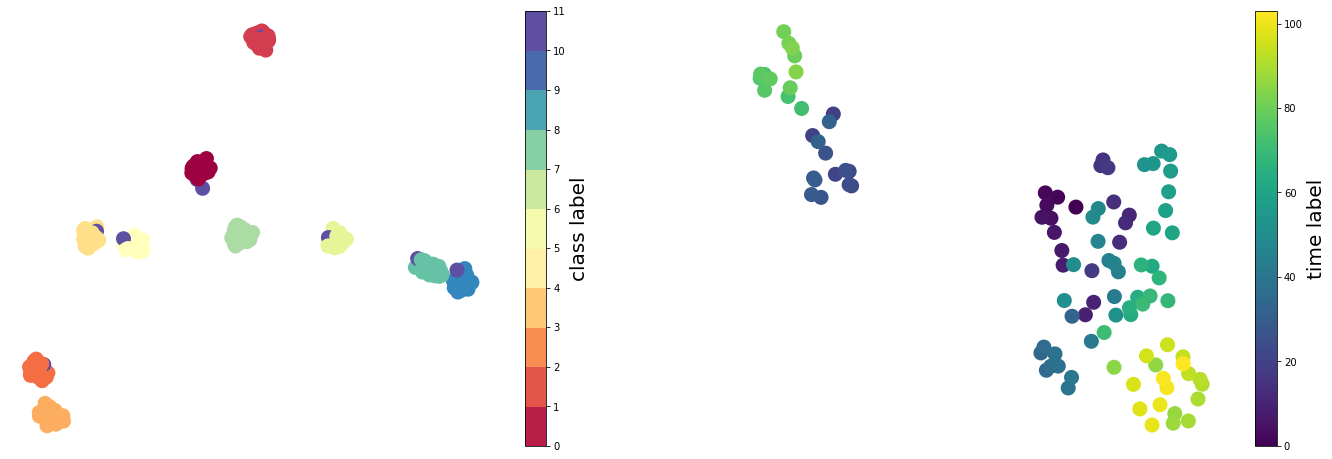

In [16]:
# plot W and T with class labels (left) and time labels (right)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(24, 8))

cb = ax[0].scatter(X[:,0], X[:,1],\
                 s=100, linewidths=5, c=get_labels(dataset, pat_active_time), cmap='Spectral')
colb = plt.colorbar(cb, ticks=np.arange(len(metadata.label.unique())+1),\
                    boundaries=np.arange(len(metadata.label.unique())+1),
                   ax=ax[0])
colb.set_label('class label', fontsize=20)
ax[0].axis('off')

cb = ax[1].scatter(Z[:,0], Z[:,1],\
                 s=100, linewidths=5, c=np.unique(times), cmap='viridis')
colb = plt.colorbar(cb, ax=ax[1])
colb.set_label('time label', fontsize=20)
ax[1].axis('off')

In [17]:
# compute hadamard product for temporal node embeddings and apply umap
emb_WdotT = np.stack([emb_W.numpy()[int(n_active.split('-')[0])]*emb_T.numpy()[int(n_active.split('-')[1])]\
                      for n_active in node_active_time])

emb = umap.UMAP()
XZ = emb.fit_transform(emb_WdotT)

/home/spiaggesi/anaconda2/envs/tf2/lib/python3.7/site-packages/numba/typed_passes.py:271: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../anaconda2/envs/tf2/lib/python3.7/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/home/spiaggesi/anaconda2/envs/tf2/lib/python3.7/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../anaconda2/envs/tf2/lib/pyt

(-9.931591920216231,
 14.357075623829514,
 -13.94172898079439,
 10.557646186604934)

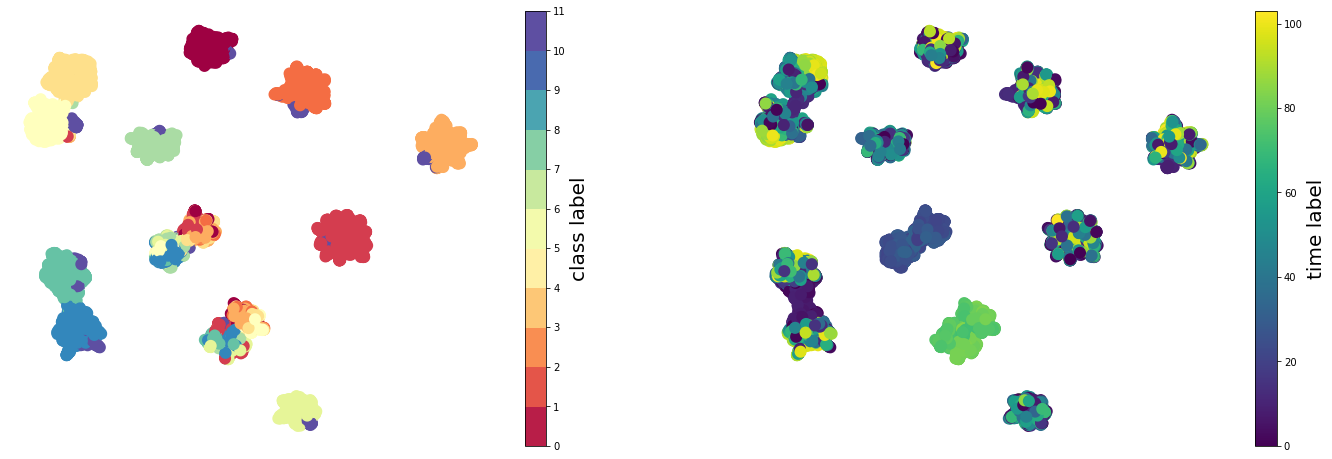

In [26]:
# plot WdotT with class labels (left) and time labels (right)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(24, 8))

cb = ax[0].scatter(XZ[:,0], XZ[:,1],\
                 s=50, linewidths=5, c=get_time_labels(dataset, pat_active_time), cmap='Spectral')
colb = plt.colorbar(cb, ticks=np.arange(len(metadata.label.unique()) +1),\
                    boundaries=np.arange(len(metadata.label.unique())+1),
                   ax=ax[0])
colb.set_label('class label', fontsize=20)
ax[0].axis('off')

cb = ax[1].scatter(XZ[:,0], XZ[:,1],\
                 s=50, linewidths=5, c=times, cmap='viridis')
colb = plt.colorbar(cb, ax=ax[1])
colb.set_label('time label', fontsize=20)
ax[1].axis('off')

## Node Classification

In [19]:
stat_res = train_test_split_predict(X=emb_WdotT, 
                                    y=get_infection_label('SIR', 0.25, 0.002, pat_active_time, dataset, AGGR_TIME), 
                                    n_splits=10,
                                    starting_test_size=0.3, 
                                    node_active_list=node_tuple_time, random_state=100)
print('F1_macro:', np.mean([r['test_result']['f1_macro'] for r in stat_res]), '+-',np.std([r['test_result']['f1_macro'] for r in stat_res]))

F1_macro: 0.5073595559179418 +- 0.03460091675072181


## Link Reconstruction

In [27]:
stat_res=[]
for train_test_dict in make_train_test_splits(n_splits=10, starting_test_size=0.3, \
                       node_active_list=node_tuple_time, df_events=df_tnet):
    emb1_train_idx, emb2_train_idx, emb3_train_idx, y_train = train_test_dict['train']
    emb1_test_idx, emb2_test_idx, emb3_test_idx, y_test = train_test_dict['test']
    X_train = emb_W.numpy()[emb1_train_idx]*emb_C.numpy()[emb2_train_idx]*emb_T.numpy()[emb3_train_idx]
    X_test = emb_W.numpy()[emb1_test_idx]*emb_C.numpy()[emb2_test_idx]*emb_T.numpy()[emb3_test_idx]
    
    model_clf = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000, n_jobs=6))
    y_test_pred = model_clf.fit(X_train, y_train).predict(X_test)
    stat_res.append(f1_score(y_test, y_test_pred, average='macro'))
print('F1_macro:', np.mean(stat_res), '+-', np.std(stat_res))

F1_macro: 0.9670672996818606 +- 0.00600652873638672
